In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
from skimage.color import gray2rgb
from tqdm import tqdm
import tifffile
from PIL import Image
import json
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
adata = sc.read("../xenium_outs/adata_complete_reduced.h5ad")

In [4]:
from anndata import AnnData

In [5]:
import seaborn as sns
sc.set_figure_params(dpi=100)
sns.set(style="ticks")

In [6]:
tgf_genes = [e for e in ["ACVR1", "APC", "ARID4B", "BCAR3", "BMP2", "BMPR1A", "BMPR2", "CDH1", "CDK9", 
                        "CDKN1C", "CTNNB1", "ENG", "FKBP1A", "FNTA", "FURIN", "HDAC1", "HIPK2", "ID1", 
                        "ID2", "ID3", "IFNGR2", "JUNB", "KLF10", "LEFTY2", "LTBP2", "MAP3K7", "NCOR2", 
                        "NOG", "PMEPA1", "PPM1A", "PPP1CA", "PPP1R15A", "RAB31", "RHOA", "SERPINE1", 
                        "SKI", "SKIL", "SLC20A1", "SMAD1", "SMAD3", "SMAD6", "SMAD7", "SMURF1", "SMURF2", 
                        "SPTBN1", "TGFB1", "TGFBR1", "TGIF1", "THBS1", "TJP1", "TRIM33", "UBE2D3", 
                        "WWTR1", "XIAP", "TGFB1", "TGFBI", "TGFBR1"] if e in adata.var.index.tolist()]
pdgf_genes = [e for e in ["PDGFA", "PDGFB", "PDGFRB", "PDGFRA", 
                          "PIK3CB", "PIK3R2", "KANK1", "BIN2", "WDR48", "STAT1", "STRN", "SOS1", 
                         "PIK3CA", "KDR", "KRAS", "PDGFRA", "ETV6", "GOLGA4", "FIP1L1", "PIK3R1", 
                         "STAT3", "HRAS", "GRB2", "NRAS", "HRAS"] if e in adata.var.index.tolist()]
tgf_genes = sorted(list(set(tgf_genes)))
pdgf_genes = sorted(list(set(pdgf_genes)))

In [7]:
# sc.read("SLE_ps.h5ad")

  0%|          | 0/4 [00:00<?, ?it/s]

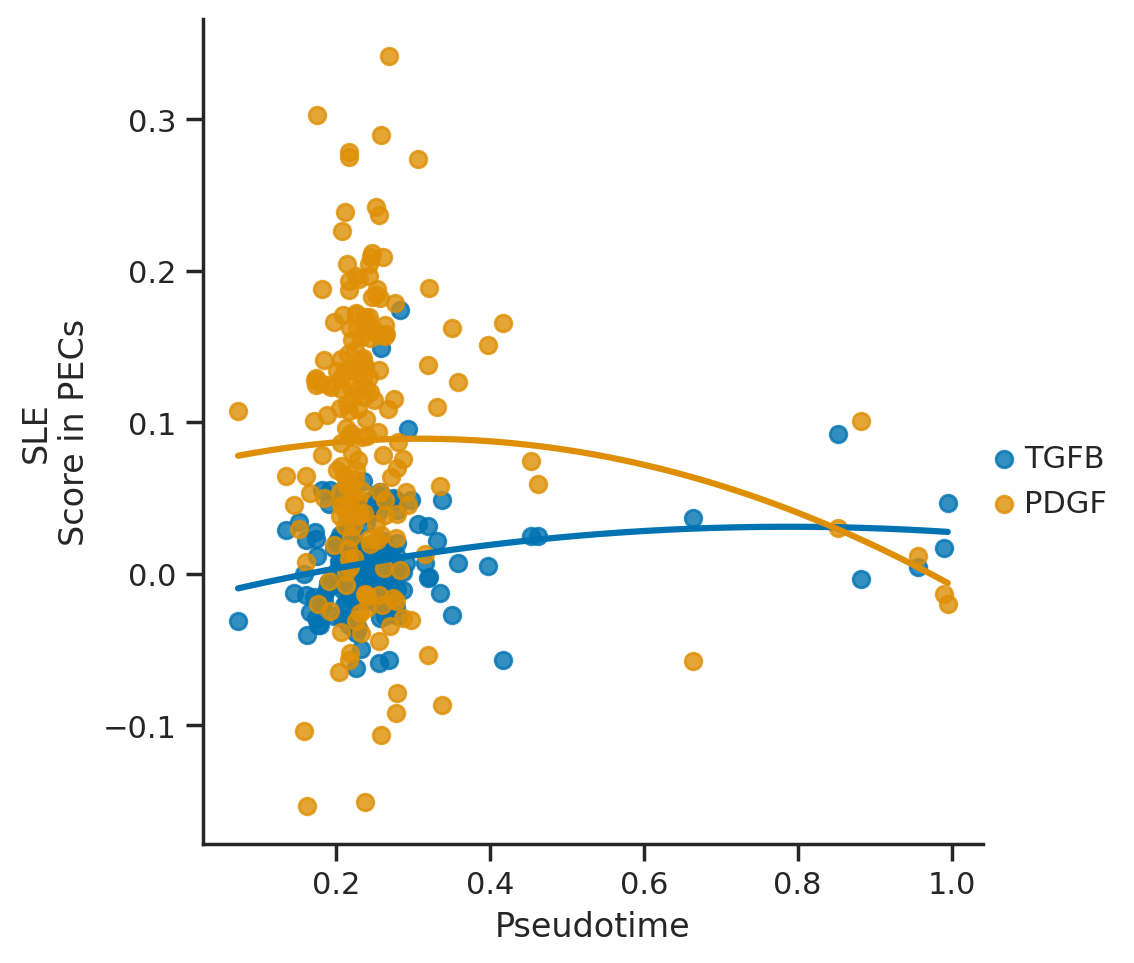

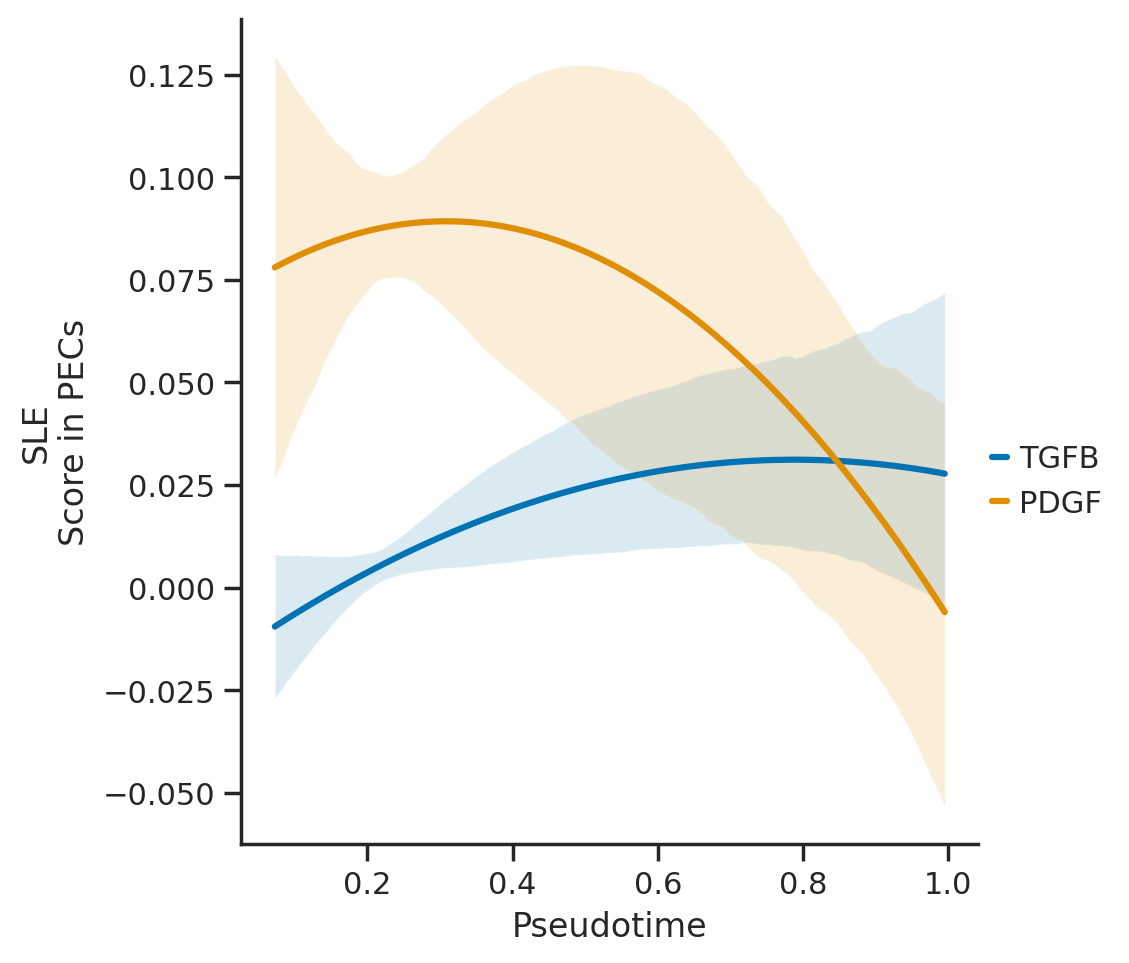

 25%|██▌       | 1/4 [00:01<00:04,  1.65s/it]

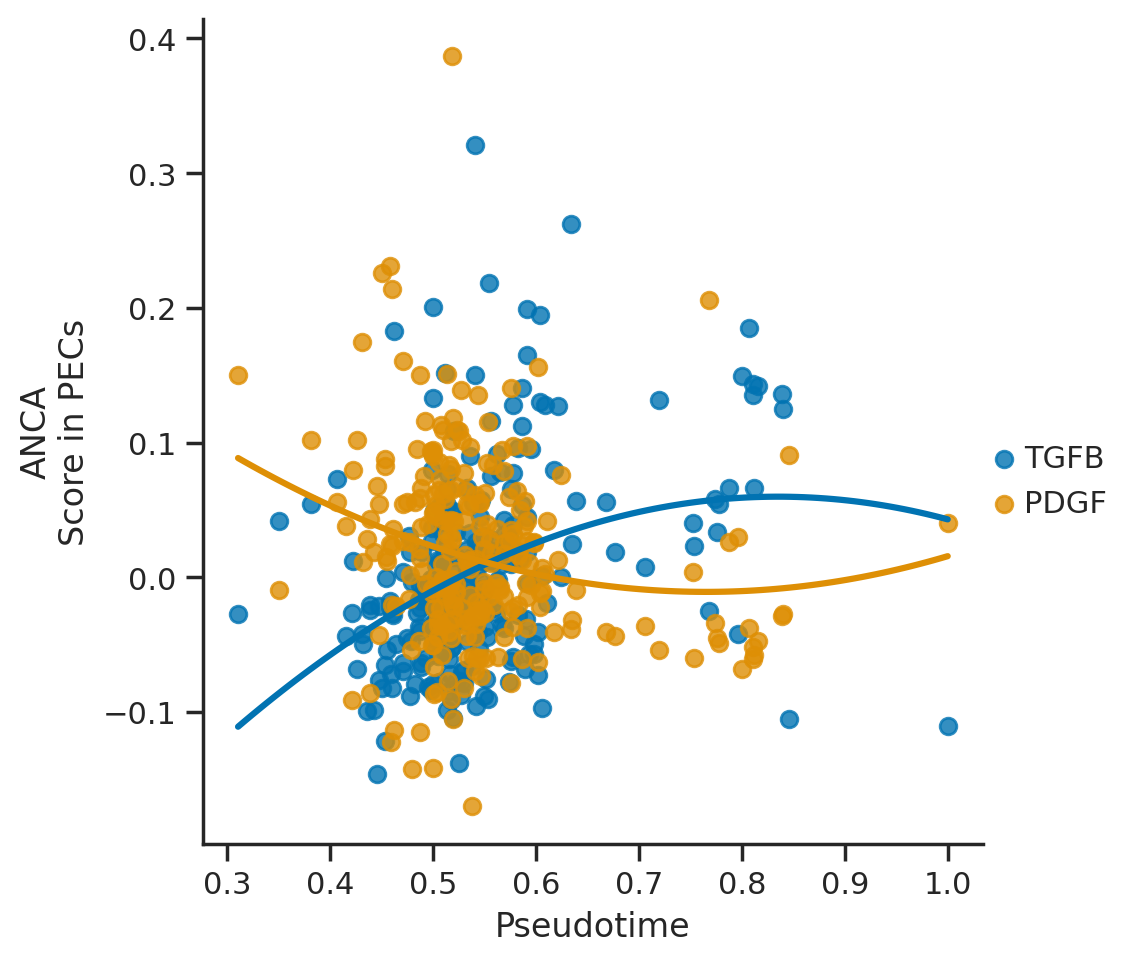

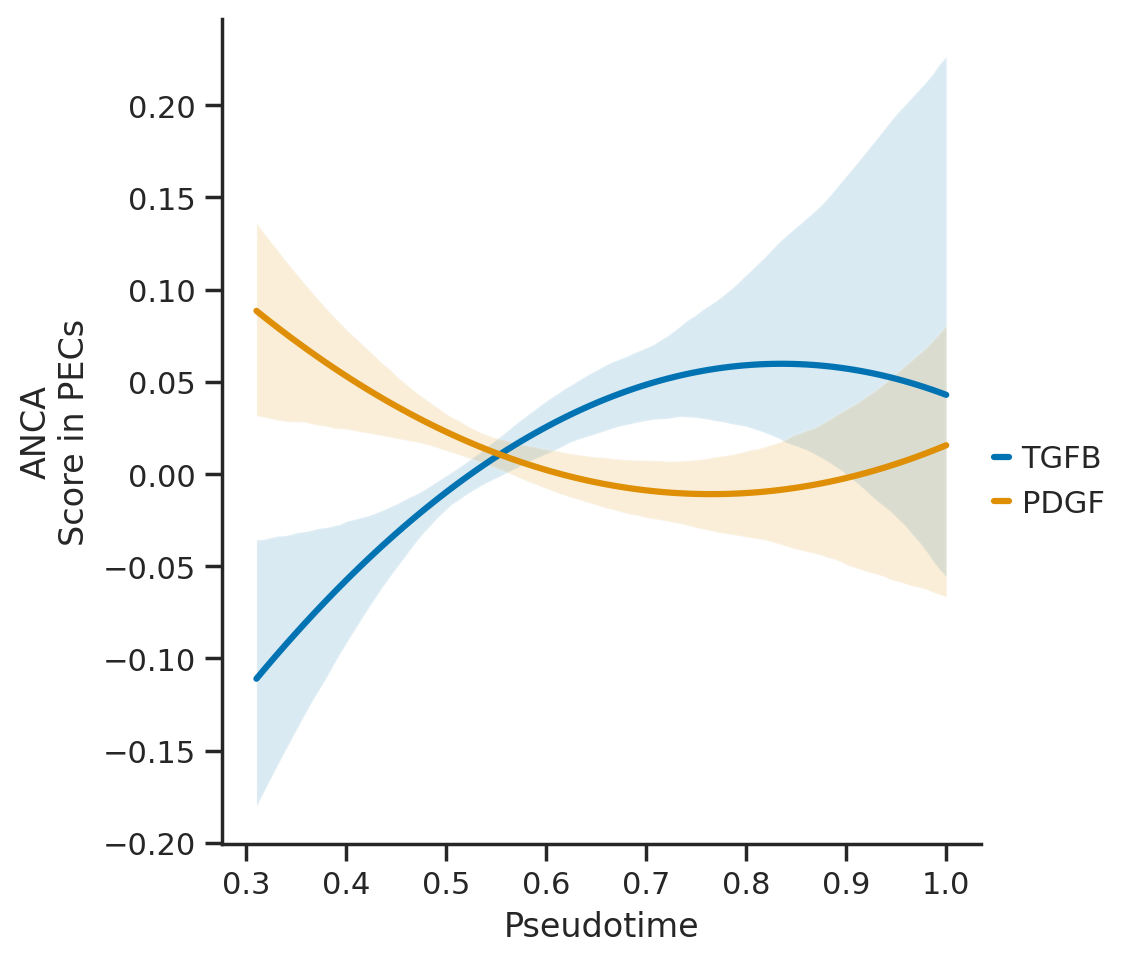

 50%|█████     | 2/4 [00:03<00:03,  1.93s/it]

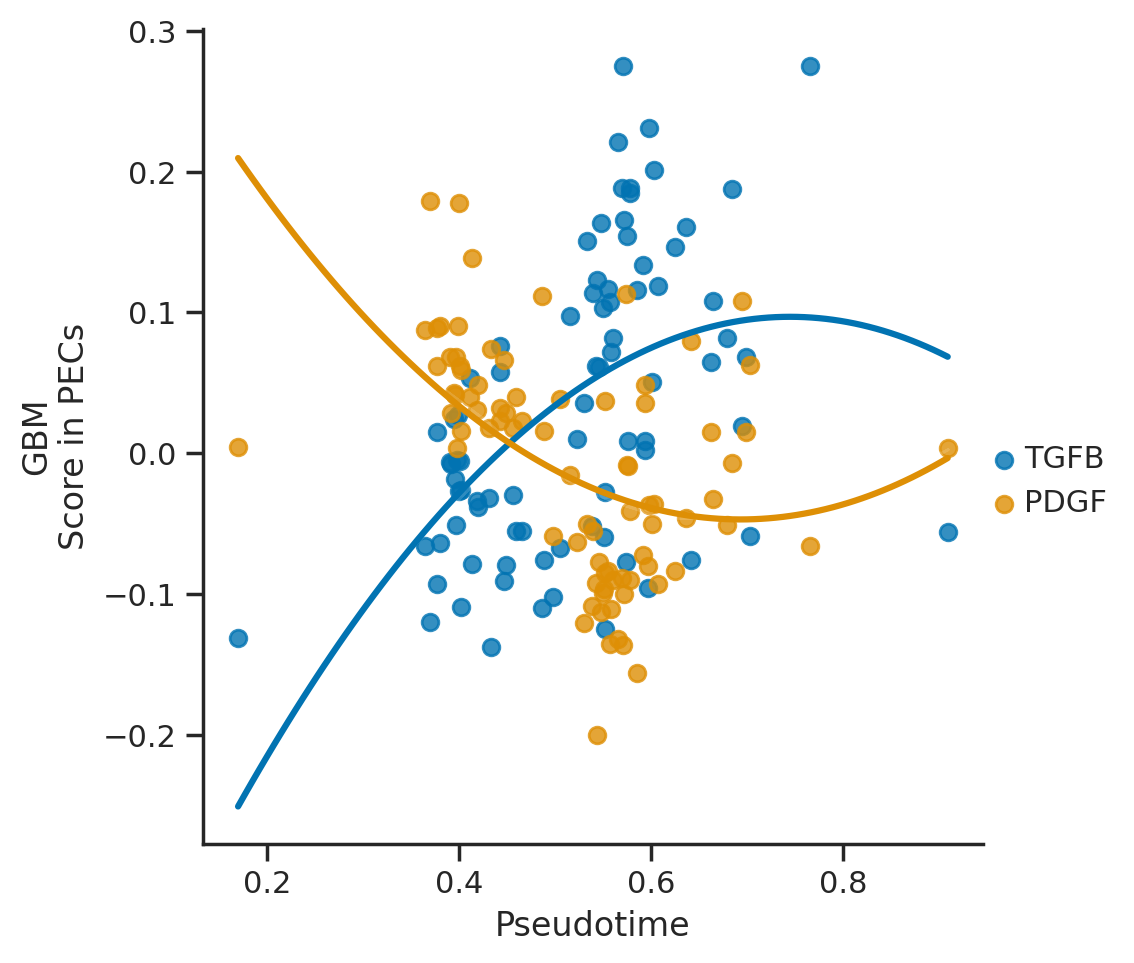

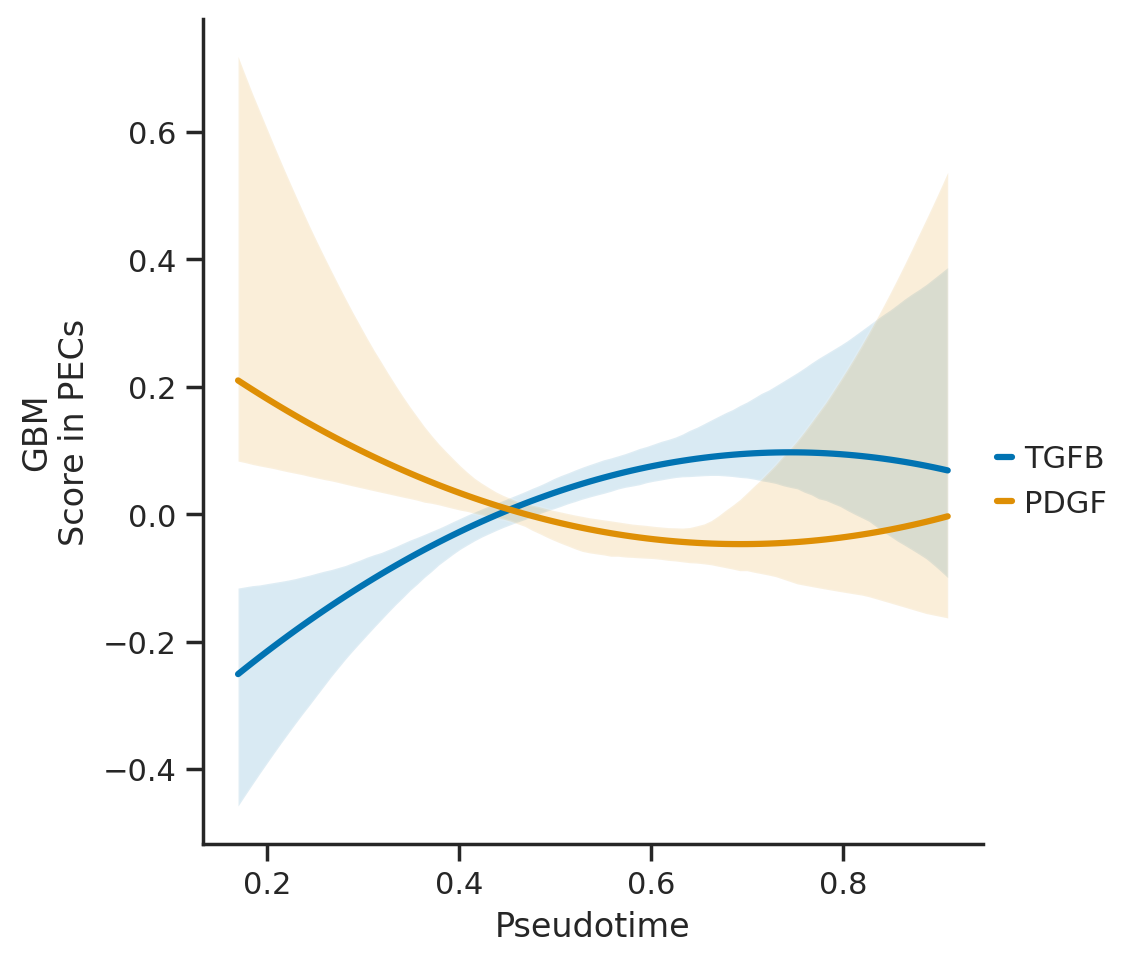

100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


In [13]:
for condition in tqdm(adata.obs.Disease.unique()):
    if condition!="Cntrl":
        df_ps = sc.read(f"{condition}_ps.h5ad")
        df_ps = df_ps[df_ps.obs.Disease!="Cntrl"]
        df_ps = df_ps.obs[["dpt_pseudotime"]]
        df_ps.rename(columns={"dpt_pseudotime": "Pseudotime"}, inplace=True)
        sub = adata[adata.obs.is_in_glom]
        sub = sub[sub.obs.Biopsy_ID.astype(str)!="nan"]
        sub = sub[sub.obs.glom_ID.isin(df_ps.index.tolist())]
        sub_1 = sub[sub.obs["celltype_l1"]=="PEC"]
        df = sub_1.to_df(layer="counts")
        df = pd.concat([df, sub_1.obs[["polygon_flags"]]], axis=1)
        df = df.groupby("polygon_flags").agg("mean")
        adata_glom_PECs = AnnData(df, obs=df_ps.loc[df.index.tolist()])
        sc.pp.normalize_total(adata_glom_PECs)
        sc.pp.log1p(adata_glom_PECs)
        sc.tl.score_genes(adata_glom_PECs, tgf_genes, score_name="TGFB", use_raw=False)
        sc.tl.score_genes(adata_glom_PECs, pdgf_genes, score_name="PDGF", use_raw=False)
        obs1 = adata_glom_PECs.obs[["Pseudotime"]]
        obs1["expression"] = adata_glom_PECs.obs["PDGF"].tolist()
        obs1["gene"] = "PDGF"
        obs2 = adata_glom_PECs.obs[["Pseudotime"]]
        obs2["expression"] = adata_glom_PECs.obs["TGFB"].tolist()
        obs2["gene"] = "TGFB"
        obs = pd.concat([obs2, obs1], axis=0)
        
        ax=sns.lmplot(data=obs,x="Pseudotime",y="expression", hue="gene", order=2, ci=False, scatter=True, palette="colorblind")
        ax.set_ylabels(f"{condition}\nScore in PECs")
        ax.legend.set_title("")
        plt.savefig(f"{condition}_PDGF_TGF.pdf", bbox_inches="tight")
        plt.show()

        ax=sns.lmplot(data=obs,x="Pseudotime",y="expression", hue="gene", order=2, ci=95, scatter=False, palette="colorblind")
        ax.set_ylabels(f"{condition}\nScore in PECs")
        ax.legend.set_title("")
        plt.savefig(f"{condition}_PDGF_TGF.pdf", bbox_inches="tight")
        plt.show()

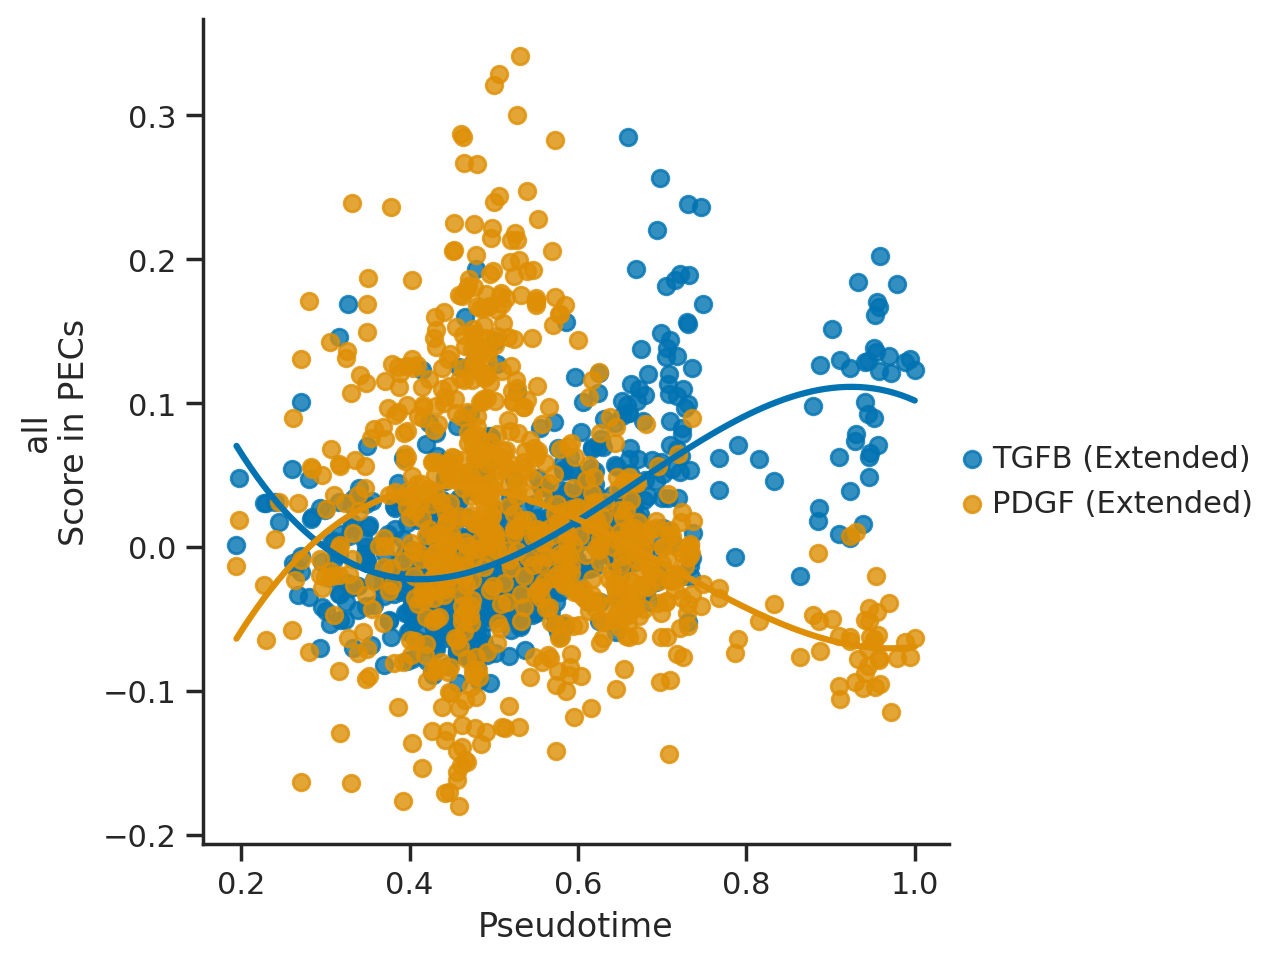

In [40]:
condition = "all"
df_ps = sc.read(f"{condition}_ps.h5ad")
df_ps = df_ps.obs[["dpt_pseudotime"]]
df_ps.rename(columns={"dpt_pseudotime": "Pseudotime"}, inplace=True)
sub = adata[adata.obs.is_in_glom]
sub = sub[sub.obs.Biopsy_ID.astype(str)!="nan"]
sub = sub[sub.obs.glom_ID.isin(df_ps.index.tolist())]
sub_1 = sub[sub.obs["celltype_l1"]=="PEC"]
df = sub_1.to_df(layer="counts")
df = pd.concat([df, sub_1.obs[["polygon_flags"]]], axis=1)
df = df.groupby("polygon_flags").agg("mean")
adata_glom_PECs = AnnData(df, obs=df_ps.loc[df.index.tolist()])
sc.pp.normalize_total(adata_glom_PECs)
sc.pp.log1p(adata_glom_PECs)
sc.tl.score_genes(adata_glom_PECs, tgf_genes, score_name="TGFB", use_raw=False)
sc.tl.score_genes(adata_glom_PECs, pdgf_genes, score_name="PDGF", use_raw=False)
obs1 = adata_glom_PECs.obs[["Pseudotime"]]
obs1["expression"] = adata_glom_PECs.obs["PDGF"].tolist()
obs1["gene"] = "PDGF (Extended)"
obs2 = adata_glom_PECs.obs[["Pseudotime"]]
obs2["expression"] = adata_glom_PECs.obs["TGFB"].tolist()
obs2["gene"] = "TGFB (Extended)"
obs = pd.concat([obs2, obs1], axis=0)

ax=sns.lmplot(data=obs,x="Pseudotime",y="expression", hue="gene", order=3, ci=None, scatter=True, palette="colorblind")
ax.set_ylabels(f"{condition}\nScore in PECs")
if condition=="SLE":
    obs = obs[obs.Pseudotime>0.5]
    ax=sns.lmplot(data=obs,x="Pseudotime",y="expression", hue="gene", order=3, ci=None, scatter=True, palette="colorblind")
    ax.set_ylabels(f"{condition}\nScore in PECs")
ax.legend.set_title("")
plt.show()

In [58]:
df_ps = 
df_ps

AnnData object with n_obs × n_vars = 974 × 480
    obs: 'Disease', 'dpt_pseudotime', 'Pseudotime'
    uns: 'Disease_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'log1p', 'neighbors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

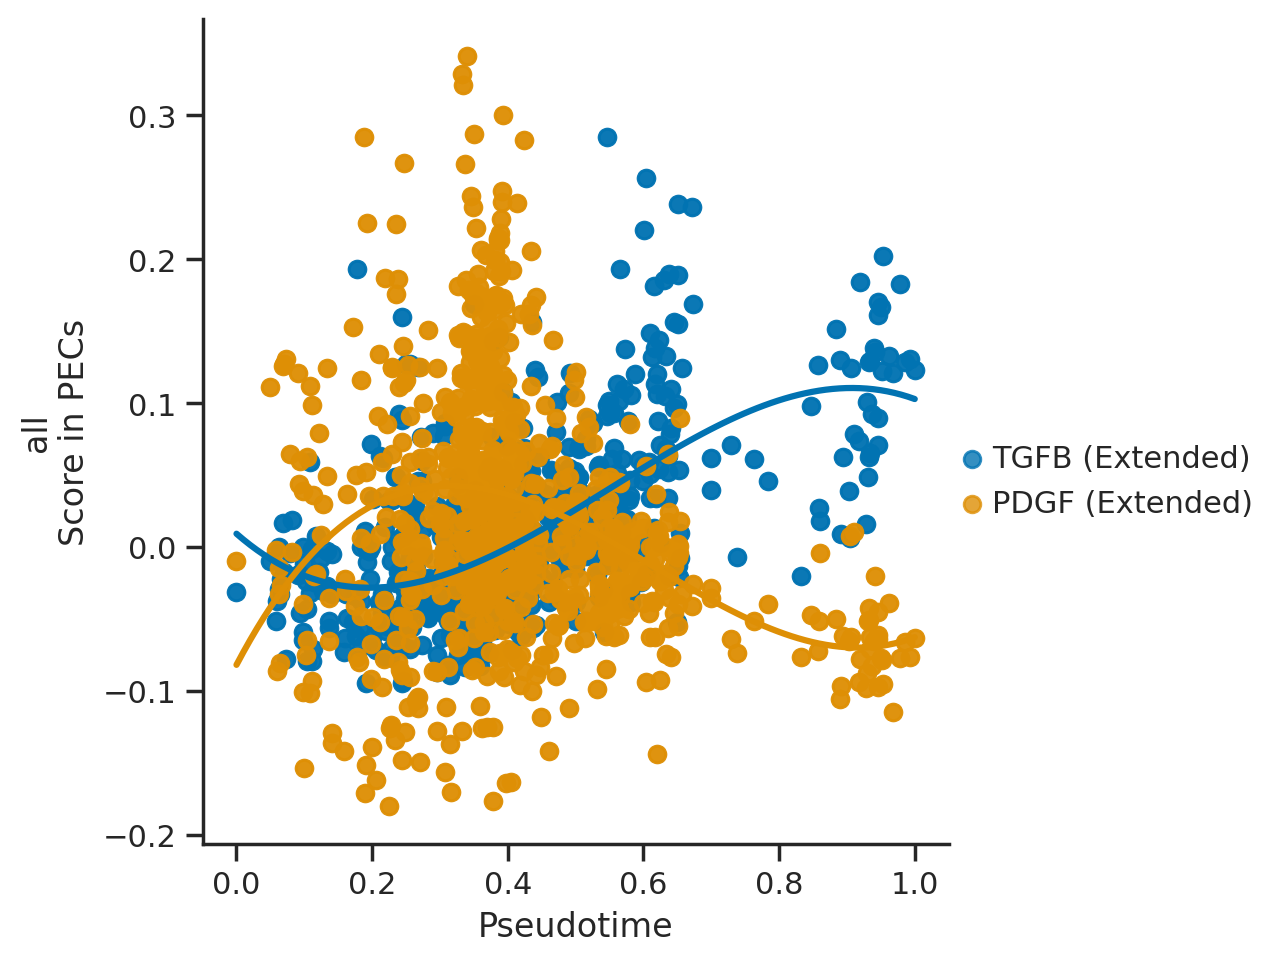

In [70]:
condition = "all"
df_ps = sc.read(f"{condition}_ps_disease_effect_removed.h5ad")
df_ps = df_ps.obs[["dpt_pseudotime"]]
df_ps = df_ps.loc[df_ps.dropna().index]
df_ps.rename(columns={"dpt_pseudotime": "Pseudotime"}, inplace=True)
sub = adata[adata.obs.is_in_glom]
sub = sub[sub.obs.Biopsy_ID.astype(str)!="nan"]
sub = sub[sub.obs.glom_ID.isin(df_ps.index.tolist())]
sub_1 = sub[sub.obs["celltype_l1"]=="PEC"]
df = sub_1.to_df(layer="counts")
df = pd.concat([df, sub_1.obs[["polygon_flags"]]], axis=1)
df = df.groupby("polygon_flags").agg("mean")
adata_glom_PECs = AnnData(df, obs=df_ps.loc[df.index.tolist()])
sc.pp.normalize_total(adata_glom_PECs)
sc.pp.log1p(adata_glom_PECs)
sc.tl.score_genes(adata_glom_PECs, tgf_genes, score_name="TGFB", use_raw=False)
sc.tl.score_genes(adata_glom_PECs, pdgf_genes, score_name="PDGF", use_raw=False)
obs1 = adata_glom_PECs.obs[["Pseudotime"]]
obs1["expression"] = adata_glom_PECs.obs["PDGF"].tolist()
obs1["gene"] = "PDGF (Extended)"
obs2 = adata_glom_PECs.obs[["Pseudotime"]]
obs2["expression"] = adata_glom_PECs.obs["TGFB"].tolist()
obs2["gene"] = "TGFB (Extended)"
obs = pd.concat([obs2, obs1], axis=0)

ax=sns.lmplot(data=obs,x="Pseudotime",y="expression", hue="gene", order=3, ci=None, scatter=True, palette="colorblind")
ax.set_ylabels(f"{condition}\nScore in PECs")
if condition=="SLE":
    obs = obs[obs.Pseudotime>0.5]
    ax=sns.lmplot(data=obs,x="Pseudotime",y="expression", hue="gene", order=3, ci=None, scatter=True, palette="colorblind")
    ax.set_ylabels(f"{condition}\nScore in PECs")
ax.legend.set_title("")
plt.show()

In [69]:
import math
(obs.expression==math.inf).sum()

0